# Hierarchical Bayesian Photo-z

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import glob
import time
import scipy.stats
import seaborn as sns

import matplotlib.patches as patches

from astropy.table import Table, join
from multiprocessing import Process, Queue

sns.set()

**Changes in response to author feedback:**
 - Treat generated t and z values as discrete, effectively tying them to the bin centers. This means dropping the `z` and `t` real-valued columns from the galaxies table, reverting to `nz=nt=50`, and updating `assign_redshifts` to work directly with bin indices.

### Introduction
This notebook goes through how to reproduce the plots in [this](https://arxiv.org/pdf/1807.11873.pdf) paper by Sánchez and Bernstein. The paper uses a Hierarchical Bayesian framework to estimate photometric redshifts. 

(write more later)

## General Utilities

This section has utilities for implementing the general infererence scheme described in Sections 2-4 of the paper. The following sections use these utilities to reproduce the demonstration in Section 5.

In [3]:
import time, sys
import IPython.display

class ProgressBar(object):
    """Replace existing contents of the current output cell with a progress bar.
    """
    def __init__(self, maxval=1., label='Progress', width=40):
        self.maxval = maxval
        self.label = label
        self.width = width
        self.start_at = time.time()
        self.update(0.)
    def update(self, value):
        elapsed = int(round(time.time() - self.start_at))
        mins = elapsed // 60
        secs = elapsed % 60
        timing = '{mins}m{secs:02d}s'.format(mins=mins, secs=secs)
        frac = value / self.maxval
        ndone = int(round(frac * self.width))
        bar = '#' * ndone + '-' * (self.width - ndone)
        text = '{label}: [{bar}]{pct:5.1f}% {timing}'.format(
            label=self.label, bar=bar, pct=100 * frac, timing=timing)
        IPython.display.clear_output(wait=True)
        print(text)

In [4]:
def dirichlet(rng, counts, alpha_offset=1.):
    """Draw a single sample from a Dirichlet distribution.

    Any bins with zero count (after adding the offset) are effectively ignored
    and have corresponding probabilities zeroed.

    Parameters
    ----------
    rng : numpy random state
        Reproducible random state.
    counts : array
        1D array of integer bin counts.
    alpha_offset : float
        Used to calculate the Dirichlet concentration parameters from the prior
        plus previous iteration bin counts. A value of 0 results in samples with a
        posterior mean of nbin / ntot for each bin, but will always return 0
        when nbin=0.  A value of 1 results in samples with a posterior mode of
        nbin / ntot for each bin, and generates random f > 0 when nbin=0 with
        a corresponding decrease in f for bins with nbin>0 in order to satisify
        sum(f) = 1.

    Returns
    -------
    array
        1D array of probabilities associated with each bin, which sum to one.
    """
    counts = np.asarray(counts)
    alpha = counts + alpha_offset
    nonzero = alpha != 0
    if np.any(nonzero):
        probs = np.zeros_like(alpha)
        probs[nonzero] = rng.dirichlet(alpha[nonzero], size=1)[0]
    else:
        probs = rng.dirichlet(alpha, size=1)[0]
    return probs

In [5]:
def categorical(rng, probs):
    """Sample from one or more categorical distributions.
    
    Uses a vectorized argmax implementation to sample from the
    inverse CDF, based on the timing tests in the Gibbs_studies notebook.
    
    Parameters
    ----------
    rng : numpy random state
        Reproducible random state.
    probs : array
        Array of probabilities to use for each category with shape (...,ncat).
        Will be normalized, so each value only needs to be non-negative.
    
    Returns
    -------
    array or int
        If probs is 1D, return a single int for the sampled category. Otherwise,
        return an array of shape (...) where probs has shape (...,ncat). Each
        category sample is an integer in the range [0, ncat).
    """
    probs = np.asarray(probs)
    # How many categories are there?
    ncat = probs.shape[-1]
    # Normalize along last axis.
    probs /= probs.sum(axis=-1, keepdims=True)
    # Calculate CDFs for each sample.
    cdfs = probs.cumsum(axis=-1)
    # Generate a uniform deviate for each sample.
    u = rng.uniform(size=probs.shape[:-1] + (1,)).astype(probs.dtype)
    # Find the index of the first CDF entry that is larger than the uniform deviate.
    return np.argmax(cdfs > u, axis=-1)

In [6]:
class HBMSampler(object):
    
    def __init__(self, nz, nt, prior_zt, likelihood, alpha_offset=0.001, seed=123):
        """
        """
        self.nz = nz
        self.nt = nt
        self.alpha_offset = alpha_offset
        self.rng = np.random.RandomState(seed)
        if prior_zt is not None:
            self.prior_counts = np.bincount(prior_zt, minlength=nz * nt)
        else:
            self.prior_counts = np.zeros(nz * nt, int)
        

In [7]:
def gibbs_step1(nzt, previous_zt=None, prior_zt=None, rng=None, alpha_offset=1.):
    """Perform the first step of a single Gibbs sample.
    
    Draw a sample from the conditional posterior P(f | N) where N represents the
    combined flattened histogram counts for the previous iteration and prior and
    f are the per-bin probabilities that sum to one.

    Parameters
    ----------
    nzt : int
        Total number of (flattened) redshift-phenotype bins.
    previous_zt : array or None
        1D array of redshift-phenotype bin indices from the previous Gibbs sample,
        or None if this is the first sample.
    prior_zt : array or None
        1D array of redshift-phenotype bin indices for the prior sample to use,
        or None to use a non-informative prior.
    rng : numpy random state or None
        Random state to use for reproducible random numbers.
    alpha_offset : float
        Used to calculate the Dirichlet concentration parameters from the prior
        plus previous redshift-phenotype bin counts. A value of 0 results in samples with a
        posterior mean of nbin / ntot for each bin, but will always return 0
        when nbin=0.  A value of 1 results in samples with a posterior mode of
        nbin / ntot for each bin, and generates random f > 0 when nbin=0 with
        a corresponding decrease in f for bins with nbin>0 in order to satisify
        sum(f) = 1.
    
    Returns
    -------
    tuple
        Tuple (probs_zt, counts_zt) of 1D arrays of length nzt, where probs_zt gives
        the probabilities associated with each redshift-phenotype bin, which sum to one, and
        counts_zt gives the corresponding integer bin counts.
    """
    counts = np.zeros(nzt, int)
    # Histogram the previous iteration.
    if previous_zt is not None:
        counts += np.bincount(previous_zt, minlength=nzt)
    if prior_zt is not None:
        # Could cache these counts for the usual case where prior_zt is always the same.
        counts += np.bincount(prior_zt, minlength=nzt)
    # Calculate the Dirichlet concentration parameters from the bin counts.
    alpha = counts + alpha_offset
    # Return a single Dirichlet sample.
    rng = rng or np.random.RandomState()
    return dirichlet(rng, counts, alpha_offset), counts

In [8]:
def gibbs_step2(probs_zt, likelihood, rng=None):
    """Perform the second step of a single Gibbs sample.
    
    TODO:
    - add bias to the (1 + delta) contribution to probs.
    - use ngal subset chunks to limit size of the 3D probs array.
    
    Parameters
    ----------
    probs_zt : array
        1D array of redshift-phenotype bin probabilities with length nzt that sum to one.
        Normally obtained as the output of :func:`gibbs_step1`.
    likelihood : array
        2D array of shape (ngal, nzt) of (relative) likelihoods for each galaxy's
        observed sky position and features for each possible redshift-phenotype bin.
    rng : numpy random state or None
        Random state to use for reproducible random numbers.
        
    Returns
    -------
    array
        1D array of length ngal giving the assigned redshift-phenotype bin
        index for each galaxy after this step as iz * nt + it with 0 <= iz < nz
        and 0 <= it < nt.
    """
    rng = rng or np.random.RandomState()
    # Calculate probs for all samples in a 2D array of shape (ngal, nz * nt).
    probs = likelihood * probs_zt
    # Sample a category [0, ntot) for each galaxy.
    return categorical(rng, probs)

## Demonstration

#### Set up global variables:

In [9]:
N = 100000 ## number of galaxies in the photometric sample
nz = 50 ## number of redshift bins
nt = 50 ## number of type bins
nx = 1024 ## number of pixels in each dimension of density field
a = 1.5 ## model parameter for type distribution (see Eq. 34)
t0 = 0.3 ## model parameter for type distribution (see Eq. 34)
sig_F = 0.02 ## scale for feature likelihood
seed = 11
rng = np.random.RandomState(seed)

#### Define functions we'll be using throughout the notebook:

In [10]:
def setup_bins(nz, nt):
    
    '''
    Parameters:
    -----------
    
    nz: Number of redshift bins.
    
    nt: Number of type bins.
    
    Returns:
    --------
    
    z_bins: np.array() containing the redshift bin edges.
    
    z_mdpt: np.array() containing the redshift bin centers.
    
    t_bins: np.array() containing the type bin edges.
    
    t_mdpt: np.array() containing the type bin centers.
    
    '''
    
    z_bins = np.linspace(0, 1, nz+1)
    z_mdpt = (z_bins[1:] + z_bins[:-1]) / 2
    t_bins = np.linspace(0, 1, nt+1)
    t_mdpt = (t_bins[1:] + t_bins[:-1]) / 2
    
    return(z_bins, z_mdpt, t_bins, t_mdpt)

## Inverse transform sample
def sample(uniform, x_interp, size, rng):
    
    '''
    Parameters:
    -----------
    
    uniform:  Array of values sampled from a uniform distribution between [0,1] 
              over which the x_interp is interpolated over.
              
    x_interp: The domain of the CDF that has been interpolated over uniform.
    
    size:     Number of samples to be drawn.
    
    rng:      Instance of np.random.RandomState().
    
    Returns:
    --------
    
    Sampled values over the domain. 
    
    '''
    
    ## uniform is proxy for the CDF
    rndm = rng.uniform(size=size)
    idx = [(np.abs(uniform - rndm[ii])).argmin() for ii in range(size)]
    return(x_interp[idx])


# Discrete implementation of eqn (35) using bin indices.
def assign_redshifts(t_bin, rng, offset=1):
    u = rng.uniform(size=len(t_bin))
    # dt will be 0 with 60% prob, +1 with 20% prob and -1 with 20% prob.
    dt = 1 * (u > 0.8) - 1 * (u < 0.2)
    # Apply dt offets
    z_bin = np.array(t_bin) + dt
    # Clamp z_bin values, effectively changing the probs in the first
    # and last bin to 80% / 20%.
    z_bin[z_bin == -1] = 0
    z_bin[z_bin == nz] = nz - 1
    return z_bin

## Feature distribution
def feature_likelihood(t, scale, rng):
    
    '''Sample a feature value for each galaxy from a normal 
    distribution centered on the galaxy's type.
    
    Parameters:
    -----------
    
    t:     An array of type values 
    scale: The standard deviation of the flux distribution.
    rng:   Instance of np.random.RandomState()
    
    Returns:
    --------
    
    Feature values for each galaxy in the sample. 
    
    '''
    return(scipy.stats.norm.rvs(loc=t, scale=scale, random_state=rng))

## Delta field
def fftIndgen(n):
    
    '''Generate grid of k values over which to calculate 
       power spectrum.
    
    Parameters:
    -----------
    
    n: Dimension of delta field.
    
    Returns:
    --------
    
    Grid of k values from -(n/2 +1) to n/2 over which to calculate the power spectrum.
    
    '''
    a = range(0, int(n/2)+1)
    b = range(1, int(n/2))
    b = reversed(b)
    a = [i for i in a]
    b = [-i for i in b]
    return a + b

def gaussian_random_field(rng, Pk = lambda k : k**-3.0, size = 1024):

    '''
    Generate a Gaussian random field.
    
    Parameters:
    -----------
    
    Pk: Function to compute the power spectrum.
    
    size: Dimension of delta field. 
    
    Returns:
    --------
    
    Amplitude of delta field in position (ra, dec) space. 
    '''
    kvec = np.asarray(fftIndgen(size))
    kgrid = np.sqrt(kvec.reshape(-1, 1) ** 2 + kvec ** 2)
    amplitude = np.zeros_like(kgrid)
    amplitude[kgrid != 0] = np.sqrt(Pk(kgrid[kgrid != 0]))
    noise = np.fft.fft2(rng.normal(size = (size, size)))
    return np.fft.ifft2(noise * amplitude)

def delta_field(nx, nz, rms=2.5, seed=123):
    
    '''
    Generate a Gaussian random field for each redshift slice. 
    
    Parameters:
    -----------
    
    nx: Number of pixels in x-direction of delta field (ra).
    nz: Number of pixels in y-direction of delta field (dec).
    rms: Variance of GRF.
    
    Returns:
    --------
    
    An array of shape (nx, nx, nz) containing the density of 
    galaxies in each redshift slice. 
    '''
    delta = np.empty((nz,nx,nx))
    rng = np.random.RandomState(seed)
    Pk = lambda k: k**-3.0
    for i in range(nz):
        z_slice = gaussian_random_field(rng, Pk, size=nx).real
        ## set variance = 2.5
        delta[i] = (z_slice / np.std(z_slice)) * rms
    return(delta)

def get_positions(rho, z_indices, nx, nz, N, rng):
    
    '''
    Get (ra,dec) position for each galaxy.
    
    Parameters:
    -----------
    
    rho: The over-density field (as defined in Eq. 33)
    
    z_indices: The redshift bin that a galaxy falls into. 
    
    nx: 
    
    nz: 
    
    N:
    
    rng:
    
    Returns:
    --------
    
    Ra,Dec positions for each galaxy.
    
    '''
    
    rho_flat = rho.reshape(nz, nx*nx)
    cdf = np.cumsum(rho_flat, axis=1)
    cdf /= cdf[:, -1].reshape(-1, 1)

    theta_bin = np.empty(N, dtype=int)

    for i in range(nz):
        galaxies_index = np.argwhere(z_indices == i).reshape(-1)
        num_galaxies = len(galaxies_index)
        if num_galaxies == 0:
            continue
        u = rng.uniform(size=num_galaxies)
        indices = np.searchsorted(cdf[i], u)
        theta_bin[galaxies_index] = indices
    
    return theta_bin

Use the options below to control whether the sample is reloaded or generated and saved.  Use `reload=False` and `save=True` if this is the first time running this notebook.

In [11]:
data_dir = '../data/bernstein_data/'
reload = False #True
save = True #False

#### Setup redshift and type bins and midpoints:

In [12]:
z_bins, z_mdpt, t_bins, t_mdpt = setup_bins(nz=nz, nt=nt)

In [13]:
if reload:
    rho = np.load(data_dir+'rho_seed11.npy')
    delta = rho - 1
    galaxies = Table.read(data_dir+'galaxies_seed11.fits', format='fits')

#### Create table to store initial galaxy values:

In [14]:
if not reload:
    col_names = ['F', 'z_bin', 't_bin', 'theta_bin']
    galaxies = Table(data=np.full((N,len(col_names)), 0), 
                     names=(col_names))

### 1. Sample types

In [15]:
t_grid = np.linspace(0., 1., 201)
pt_grid = t_grid ** a * np.exp(-(t_grid / t0) ** a)
if not reload:
    pt_cdf = np.cumsum(pt_grid)
    pt_cdf /= pt_cdf[-1]
    t_val = np.interp(rng.uniform(size=N), pt_cdf, t_grid)
    galaxies['t_bin'] = np.digitize(t_val, t_bins) - 1

### 2. Sample redshifts

In [16]:
if not reload:
    galaxies['z_bin'] = assign_redshifts(galaxies['t_bin'], rng)

### 3. Sample features

In [17]:
if not reload:
    galaxies['F'] = feature_likelihood(t_mdpt[galaxies['t_bin']], scale=sig_F, rng=rng)

### 4. Sample positions

In [18]:
if not reload:
    ## First generate the density field
    delta = delta_field(nx, nz)
    rho = np.maximum(0, delta + 1)
    galaxies['theta_bin'] = get_positions(rho, galaxies['z_bin'], nx, nz, N, rng)

Save the generated sample so it can be reloaded next time:

In [19]:
if save:
    galaxies.write(data_dir + 'galaxies_seed{}.fits'.format(seed), format='fits', overwrite=True)
    np.save(data_dir + 'rho_seed{}'.format(seed), rho)

#### Let's make sure everything looks OK...

In [20]:
fs = 14

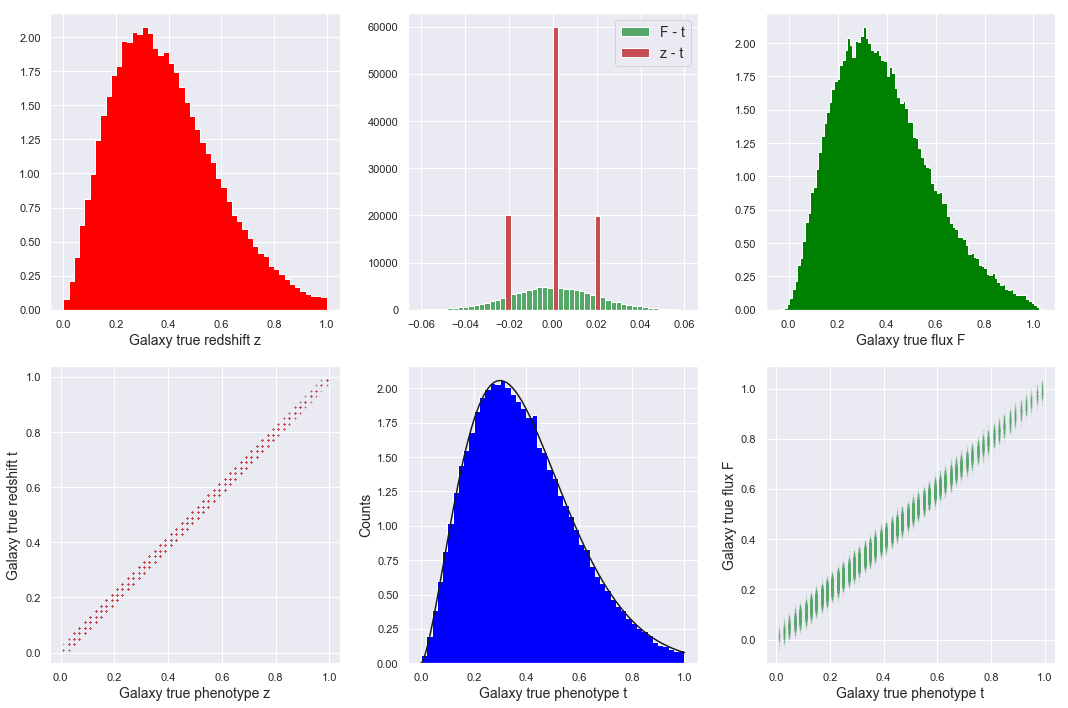

In [21]:
fig, axs = plt.subplots(2,3, figsize=(15,10))
axs = axs.ravel()

axs[0].hist(z_mdpt[galaxies['z_bin']], bins=z_bins, color='red', histtype='stepfilled', density=True)
axs[0].set_xlabel('Galaxy true redshift z', fontsize=fs)

_, bins, _ = axs[1].hist(galaxies['F'] - t_mdpt[galaxies['t_bin']], color='g',  bins=50,
                         range=(-3 * sig_F, +3 * sig_F), label='F - t')
axs[1].hist(z_mdpt[galaxies['z_bin']] - t_mdpt[galaxies['t_bin']], bins=bins, color='r', label='z - t')
axs[1].legend(fontsize=fs)

axs[2].hist(galaxies['F'], bins=100, color='green', histtype='stepfilled', density=True)
axs[2].set_xlabel('Galaxy true flux F', fontsize=fs)

axs[3].plot(t_mdpt[galaxies['t_bin']], z_mdpt[galaxies['z_bin']], 'r.', ms=1, alpha=0.01)
axs[3].set_xlabel('Galaxy true phenotype z', fontsize=fs)
axs[3].set_ylabel('Galaxy true redshift t', fontsize=fs)

axs[4].hist(t_mdpt[galaxies['t_bin']], bins=t_bins, color='blue', histtype='stepfilled', density=True)
axs[4].plot(t_grid, pt_grid / pt_grid.sum() / np.gradient(t_grid), 'k-')
axs[4].set_ylabel('Counts', fontsize=fs)
axs[4].set_xlabel('Galaxy true phenotype t', fontsize=fs)

axs[5].plot(t_mdpt[galaxies['t_bin']], galaxies['F'], 'g.', ms=1, alpha=0.1)
axs[5].set_xlabel('Galaxy true phenotype t', fontsize=fs)
axs[5].set_ylabel('Galaxy true flux F', fontsize=fs)

plt.tight_layout()
plt.show()

### Reproduction of Figure 2

In [22]:
def figure2(frac=0.05, theta_x0=nx // 4, theta_y0=nx // 2):

    fig, axs = plt.subplots(5, 10, figsize=(16, 8))
    axs = axs.ravel()

    unique, counts = np.unique(galaxies['z_bin'], return_counts=True)
    ## Only plot a random 5% subsample of 
    n_subsamples = np.round(counts * frac).astype(int)

    theta_bin = galaxies['theta_bin'].data
    theta_y = theta_bin // nx
    theta_x = theta_bin % nx
    
    for i in range(nz):
        select = galaxies['z_bin'] == i
        axs[i].imshow(rho[i], origin='lower', alpha=0.5, cmap='Reds', vmin=0, vmax=10)
        axs[i].plot(theta_x[select][:n_subsamples[i]], theta_y[select][:n_subsamples[i]], 'k.', ms=2)
        axs[i].scatter(theta_x0, theta_y0, marker='o', s=150, lw=2, edgecolors='g', facecolors='none')
        axs[i].axis('off')

    plt.subplots_adjust(hspace=0.01, wspace=0.01)
    plt.show()
    
    fig = plt.figure(figsize=(16, 2))
    plt.hist(z_mdpt, bins=z_bins, weights=rho[:, theta_y0, theta_x0], histtype='stepfilled', alpha=0.5, color='g')
    plt.xlim(z_bins[0], z_bins[-1])
    plt.ylabel('$1 + \\delta(z)$')

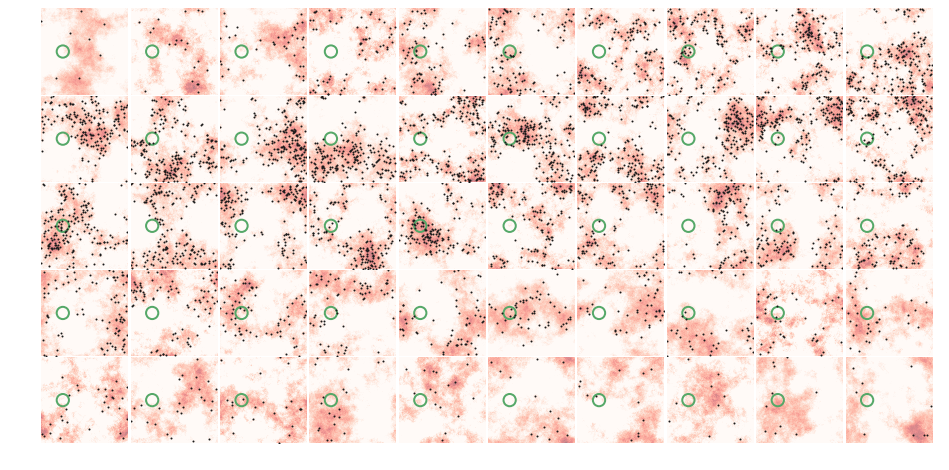

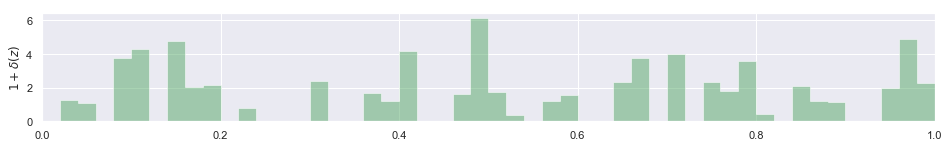

In [23]:
figure2()

**Now that we've generated our photometric data set, we will use this to reproduce the figures in section 5.1**

The results of the fiducial case use 8 x 10^4 galaxies from the initial simulation as our **photometric** sample (for which we know only F, theta), and a separate random **spectroscopic** sample of 1k galaxies as my prior (for which we z,t in addition to F,theta).

In [24]:
n_photo = 80000
n_spectro = 1000

Since the generated galaxies are already random, we just take the first 80K as the fiducial sample and the next 1K as the prior sample:

In [25]:
if reload:
    photo_data = Table.read(data_dir + 'photo_data_seed{}.fits'.format(seed))
    spectro_data = Table.read(data_dir + 'spectro_data_seed{}.fits'.format(seed))

In [26]:
if not reload:
    photo_data = galaxies[:n_photo]
    spectro_data = galaxies[n_photo:n_photo + n_spectro]

In [27]:
if save:
    photo_data.write(data_dir + 'photo_data_seed{}.fits'.format(seed), format='fits', overwrite=True)
    spectro_data.write(data_dir + 'spectro_data_seed{}.fits'.format(seed), format='fits', overwrite=True)

### Reproduce the Demonstration Chains of Section 5

I think `alpha_offset=1` is generally the *correct* choice, but the sparsity of the (z,t) space in this demonstration leads to large distortions from samples generated in the large off-diagonal area of the (z,t) plane.  Need to check with the authors what they actually did.

In [28]:
def demo_sampler(photo_data, spectro_data, n_cycles=2500, zmax=1.0, alpha_offset=0., prior=False, seed=123, save=None):
    
    rng = np.random.RandomState(seed)
        
    # Use true delta field instead of an estimator based on tracers.
    delta_est = np.transpose(delta.reshape(nz, -1))
    # Clip so that 1 + delta >= 0.
    delta_est = np.maximum(-1, delta_est)
    # Zero out slices with z > zmax.
    delta_est[:, z_mdpt > zmax] = 0.
    
    # Calculate the (z,t) bins for each spectroscopic galaxy.
    prior_zt = spectro_data['z_bin'].data * nt + spectro_data['t_bin'].data
    
    if prior:
        likelihood = np.ones(shape=(len(photo_data), nz * nt), dtype=np.float32)
        
    else:    
        # Calculate the likelihood of each photometric galaxy's features for all possible phenotypes.
        feature_likelihood = scipy.stats.norm.pdf(photo_data['F'].reshape(-1, 1), loc=t_mdpt, scale=sig_F)
        # Calculate the likelihood of each photometric galaxy's sky position for all possible redshifts.
        theta = photo_data['theta_bin'].data
        theta_likelihood = 1 + delta_est[theta]
        theta_likelihood /= theta_likelihood.sum(axis=-1, keepdims=True)
        # Combine the feature and sky position likelihoods, which are fixed during sampling.
        likelihood = (feature_likelihood.reshape(-1, 1, nt) * theta_likelihood.reshape(-1, nz, 1)).reshape(-1, nz * nt)
        # Convert to float32.
        likelihood = likelihood.astype(np.float32)
    
    previous_zt = None
    samples = np.empty((n_cycles, len(photo_data)), np.uint16)
    progress = ProgressBar(label='Gibbs Sampler', maxval=n_cycles)
    for cycle in range(n_cycles):
        probs_zt, counts_zt = gibbs_step1(nz * nt, previous_zt, prior_zt, rng, alpha_offset)
        previous_zt = samples[cycle] = gibbs_step2(probs_zt.astype(np.float32), likelihood, rng)
        progress.update(cycle + 1)
    
    if save:
        print('Saving samples to {}'.format(save))
        np.save(save, samples)
        
    return samples

Run a small benchmarking test with 10 samples. A chain with 2500 samples takes about 70 mins to run on my laptop.

In [29]:
samples = demo_sampler(photo_data, spectro_data, n_cycles=10, zmax=1.0, alpha_offset=1.0)

Gibbs Sampler: [########################################]100.0% 0m19s


Generate chains using only features F in the likelihood (zmax=0):

In [90]:
#samples_noz_1 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=1, zmax=0., save='noz_1')
#samples_noz_2 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=2, zmax=0., save='noz_2')
#samples_noz_3 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=3, zmax=0., save='noz_3')
#samples_noz_4 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=4, zmax=0., save='noz_4')

Generate chains using full clustering information (zmax=1):

In [31]:
#samples_fullz_1 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=1, save='fullz_1')
#samples_fullz_2 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=2, save='fullz_2')
#samples_fullz_3 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=3, save='fullz_3')
#samples_fullz_4 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=4, save='fullz_4')

Generate chains using partial clustering information (zmax=0.5):

In [32]:
#samples_halfz_1 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=1, zmax=0.5, save='halfz_1')
#samples_halfz_2 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=2, zmax=0.5, save='halfz_2')
#samples_halfz_3 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=3, zmax=0.5, save='halfz_3')
#samples_halfz_4 = demo_sampler(photo_data, spectro_data, n_cycles=2500, seed=4, zmax=0.5, save='halfz_4')

The generated outputs are available at NERSC in `/global/homes/d/dkirkby/HBM/demo/` as 3 tarfiles. Extract the four chains from each using:
```
tar zxf fullz.tgz
tar zxf halfz.tgz
tar zxf noz.tgz
```
The resulting 12 uncompressed numpy files are 381Mb each, and contain an array of shape (2500, 80000) of uint16 values that encode the (z, t) bin for each (sample, galaxy) as `z_bin * nt + t_bin`.

Load a set of chains using:

In [19]:
def load_chains(name, seeds=(1, 2, 3, 4)):
    shape = None
    for k, seed in enumerate(seeds):
        bins = np.load('{}_{}.npy'.format(name, seed))
        if shape is None:
            shape = bins.shape
            combined = np.empty((len(seeds),) + shape, bins.dtype)
        else:
            assert bins.shape == shape, 'Expected all chains to have the same shape.'
        combined[k] = bins
    return combined

In [20]:
data_path = '../data/bernstein_data/dkirkby_hbm_data/'

In [21]:
fullz = load_chains(data_path+'fullz')
halfz = load_chains(data_path+'halfz')
noz = load_chains(data_path+'noz')

#### Convergence Tests

Check that the 4 chains for each approach are converged using the Gelman-Rubin statistic (original paper [here](https://projecteuclid.org/euclid.ss/1177011136) with some recent developments [here](https://arxiv.org/abs/1812.09384)).

There are some ambiguities in how to apply this test:
 - was any burn-in trimmed from each chain?
 - what scalar value(s) were used from each sample to evaluate the metric, or was a multivariate generalization used?
 
Here we try without any burn-in and pick some random galaxy bin indices as the scalar values to use.

In [35]:
def gr_metric(samples, idx=0, nburnin=0):
    """Evaluate the Gelman-Rubin convergence metric.
    """
    nchain, nsample, ngal = samples.shape
    # Pick out the scalar value to use for each sample.
    X = samples[:, nburnin:, idx]
    n = nsample - nburnin
    # Calculate the mean and variance of X within each independent chain.
    chain_mean = np.mean(X, axis=1)  # Xbar_i
    chain_var = np.var(X, axis=1)    # s_i^2
    # Calculate the (unweighted) average of chain means and variances.
    mu_all = np.mean(chain_mean)     # muhat
    var_all = np.mean(chain_var)     # s^2
    # Calculate the variance of chain means.
    var_mean = np.var(chain_mean)    # B/n
    # The expectation value for var_all is n/(n - 1) (var_true - var_mean).
    # If the chains are converged, we expect var_mean = var_true / n,
    # in which case the expectation of var_all is var_true.
    # If the chains are not converged, var_mean is generally larger than
    # var_true / n, which biases var_all to a smaller value.
    # Estimate the true variance from var_all as:
    var_est = (n - 1) / n * var_all + var_mean
    # Compare var_est and var_all.
    return np.sqrt(var_est / var_all)

In [54]:
def gr_test(samples, ntest=100, nburnin=0, seed=123, ax=None, label=None):
    ax = ax or plt.gca()
    ngal = samples.shape[-1]
    rng = np.random.RandomState(seed)
    values = np.empty(ntest)
    for k, idx in enumerate(rng.choice(ngal, size=ntest, replace=False)):
        values[k] = gr_metric(samples, idx, nburnin)
    ax.hist(values - 1, bins=ntest // 5, label=label)
    ax.set_xlabel('Gelman-Rubin Convergence metric - 1')
    ax.axvline(0., c='k', ls='--')
    if label:
        ax.legend()
    print('Mean GR metric:', np.mean(values))

Mean GR metric: 0.9999513702759741


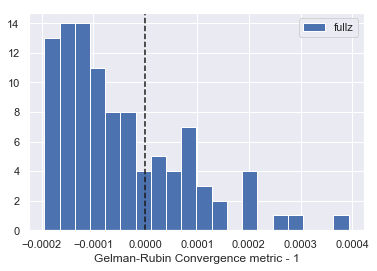

In [55]:
gr_test(fullz, label='fullz')

Mean GR metric: 0.9999658474534013


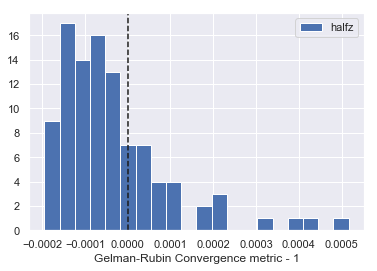

In [56]:
gr_test(halfz, label='halfz')

Mean GR metric: 1.0000737684553778


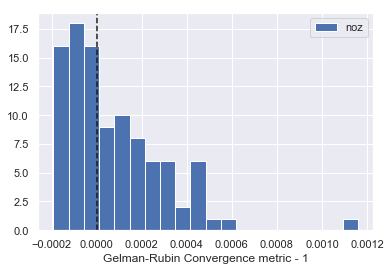

In [57]:
gr_test(noz, label='noz')

#### Figures 3 and 6

Write a function that compares the sampler output with the true redshift and type distributions:

In [58]:
def compare_distributions(photo_truth, spectro_truth, samples):
    
    fig, axs = plt.subplots(1,2, figsize=(15,6))
    axs = axs.ravel()
    
    axs[0].hist(photo_truth['z'], bins=z_bins, alpha=0.3, histtype='stepfilled', density=True, label='Photo')
    axs[0].hist(spectro_truth['z'], bins=z_bins, lw=2, histtype='step', density=True, label='Spectro')
    axs[1].hist(photo_truth['t'], bins=t_bins, alpha=0.3, histtype='stepfilled', density=True, label='Photo')
    axs[1].hist(spectro_truth['t'], bins=t_bins, lw=2, histtype='step', density=True, label='Spectro')
    
    nsamples, ngal = samples.shape
    z_norm = ngal * np.diff(z_bins)
    t_norm = ngal * np.diff(t_bins)
    
    z_pdf = np.empty((nsamples, nz))
    t_pdf = np.empty((nsamples, nt))
    for i, sample in enumerate(samples):
        z_pdf[i] = np.bincount(sample // nt, minlength=nz) / z_norm
        t_pdf[i] = np.bincount(sample % nt, minlength=nt) / t_norm
        
    def vplot(ax, x, y, c='k'):
        parts = ax.violinplot(x, y, widths=0.01, showextrema=False)
        for pc in parts['bodies']:
            pc.set_facecolor(c)
            pc.set_edgecolor(c)
            pc.set_alpha(0.8)
            
    vplot(axs[0], z_pdf, z_mdpt)
    vplot(axs[1], t_pdf, t_mdpt)

    axs[0].set_ylabel('Density', fontsize=fs)
    axs[0].set_xlabel('Redshift z', fontsize=fs)
    axs[1].set_xlabel('Phenotype t', fontsize=fs)
    
    axs[0].set_xlim(z_bins[0], z_bins[-1])
    axs[1].set_xlim(t_bins[0], t_bins[-1])
    axs[0].set_ylim(0., 3.)
    axs[1].set_ylim(0., 3.)
    
    axs[0].legend(fontsize=fs)
    axs[1].legend(fontsize=fs)
    
    plt.tight_layout()
    plt.show()

Split Figure 3 into separate plots for F (noz) and F+delta (fullz):

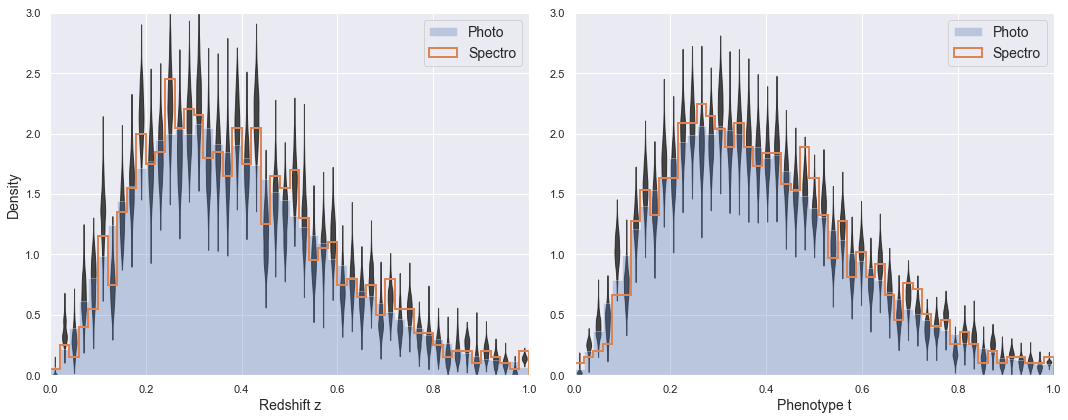

In [62]:
compare_distributions(photo_data, spectro_data, noz.reshape(-1, len(photo_data)))

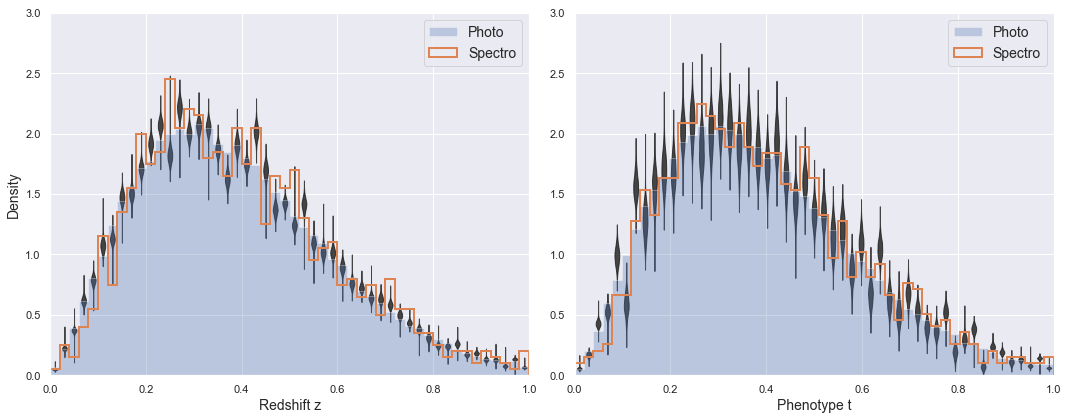

In [63]:
compare_distributions(photo_data, spectro_data, fullz.reshape(-1, len(photo_data)))

Plot the F+delta(z<0.5) part of Figure 6:

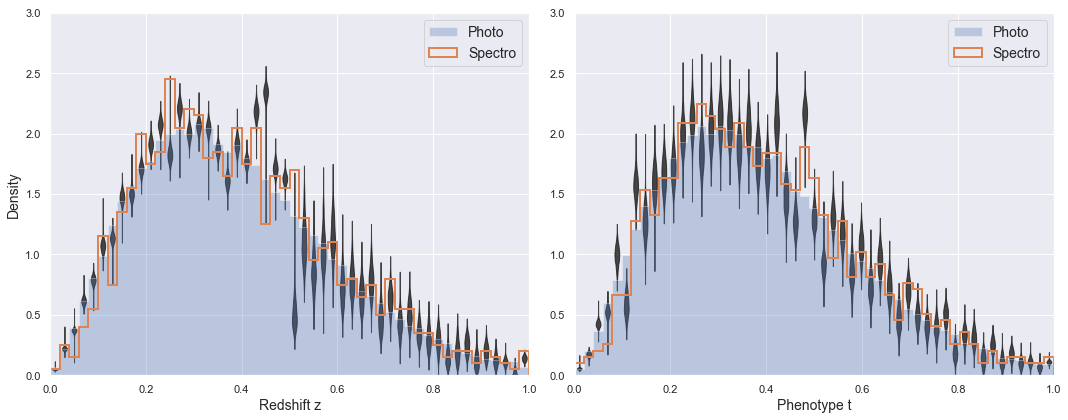

In [64]:
compare_distributions(photo_data, spectro_data, halfz.reshape(-1, len(photo_data)))

#### Figure 4

In [22]:
n_chains = 4
n_cycles = 2500
n_samples = n_chains * n_cycles

In [151]:
## still working this out...
prior_zt = spectro_data['z_bin'].data * nt + spectro_data['t_bin'].data
d_prior = gibbs_step1(n_samples, previous_zt=None, prior_zt=prior_zt, rng=np.random.RandomState(seed), alpha_offset=1.)
like = np.ones_like(d_prior[0])
sampled_d_prior = gibbs_step2(d_prior[0], like, rng=np.random.RandomState(seed))

In [107]:
def get_delz(chains):
    ## Combine data all 4 chains
    combined = chains.reshape(n_samples, -1)
    ## Extract redshift bin numbers
    zbins = combined // nt
    ## Convert from bins to z value
    zbins_to_z = [z_mdpt[zbins[i]] for i in range(n_samples)]
    zbins_to_z = np.asarray(zbins_to_z)
    ## Calculate delta z metric
    return(np.mean(zbins_to_z, axis=1) - np.mean(photo_data['z']))

In [155]:
fullz_delz = get_delz(fullz)
halfz_delz = get_delz(halfz)
noz_delz = get_delz(noz)

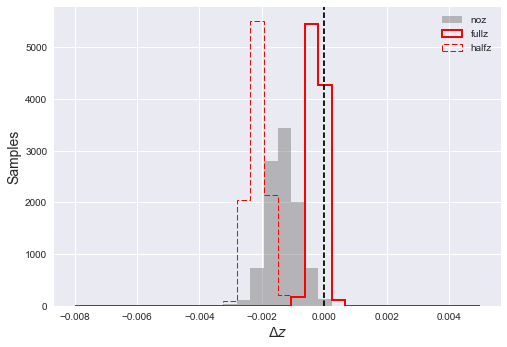

In [169]:
fs = 14
r = (-0.008, 0.005)
plt.hist(noz_delz, bins=30, range=r, label='noz', histtype='stepfilled', lw=2, color='gray', alpha=0.5)
plt.hist(fullz_delz, bins=30, range=r, label='fullz', histtype='step', lw=2, color='r')
plt.hist(halfz_delz, bins=30, range=r, label='halfz', histtype='step', lw=1, ls='--', color='r')
plt.axvline(0., c='k', ls='--')
plt.xlabel('$\Delta z$', fontsize=fs)
plt.ylabel('Samples', fontsize=fs)
plt.legend()
plt.show()

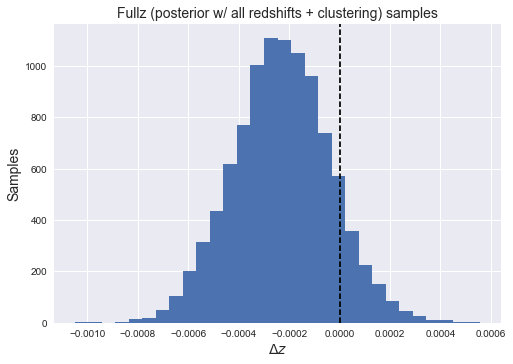

In [159]:
plt.hist(fullz_delz, bins=30)
plt.axvline(0., c='k', ls='--')
plt.title('Fullz (posterior w/ all redshifts + clustering) samples', fontsize=fs)
plt.xlabel('$\Delta z$', fontsize=fs)
plt.ylabel('Samples', fontsize=fs)
plt.show()

In [ ]:
#fullz_zhist = [np.bincount(fullz_zbins[i], minlength=nz) for i in range(n_samples)]
#np.mean(fullz_zhist[0] * z_mdpt) - np.mean(photo_data['z'])
#fullz_zhist = np.asarray(fullz_zhist)
#plt.hist(z_mdpt, bins=z_bins, weights=fullz_zhist[1])
#plt.show()

#### Figure 5

In [88]:
def plot_one(idx):
    # Look up this galaxy's true properties.
    galaxy = photo_data[idx]
    F = galaxy['F']
    theta = galaxy['theta_bin']
    t_true = galaxy['t']
    z_true = galaxy['z']
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    for label, samples, style in zip(
        ('$F_i$', '$F_i + \\delta(\\theta_i)$', '$F_i + \\delta(\\theta_i, z < 0.5)$'),
        (noz.reshape(-1, n_photo), fullz.reshape(-1, n_photo), halfz.reshape(-1, n_photo)),
        (dict(histtype='stepfilled', color='gray', alpha=0.5),
         dict(histtype='step', color='r', lw=2),
         dict(histtype='step', color='r', ls='--', lw=1))):
        
        # Extract (z,t) bin indices for each sample.
        z_bin = samples[:, idx] // nt
        t_bin = samples[:, idx] % nt
        # Histogram bin indices.
        z_hist = np.bincount(z_bin, minlength=nz)
        t_hist = np.bincount(t_bin, minlength=nt)
        # Show histograms.
        ax[0].hist(z_mdpt, bins=z_bins, weights=z_hist, label=label, **style)
        ax[1].hist(t_mdpt, bins=t_bins, weights=t_hist, label=label, **style)
        
    ax[0].axvline(z_true, c='k', ls=':', lw=2)
    ax[1].axvline(t_true, c='k', ls=':', lw=2)
    ax[0].set_xlabel('Redshift')
    ax[1].set_xlabel('Phenotype')
    ax[0].set_ylabel('Samples')
    ax[1].set_ylabel('Samples')
    ax[0].set_xlim(z_bins[0], z_bins[-1])
    ax[1].set_xlim(t_bins[0], t_bins[-1])
    ax[0].legend()
    ax[1].legend()
    plt.tight_layout()

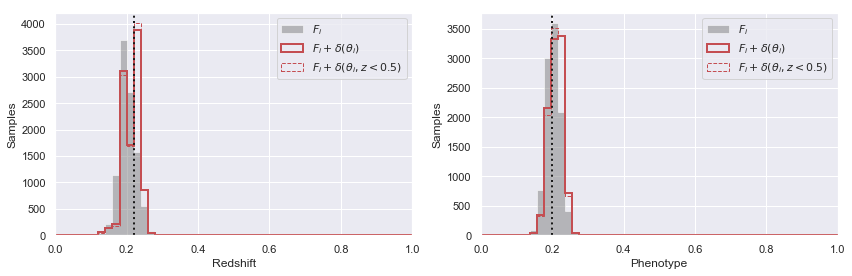

In [89]:
plot_one(0)

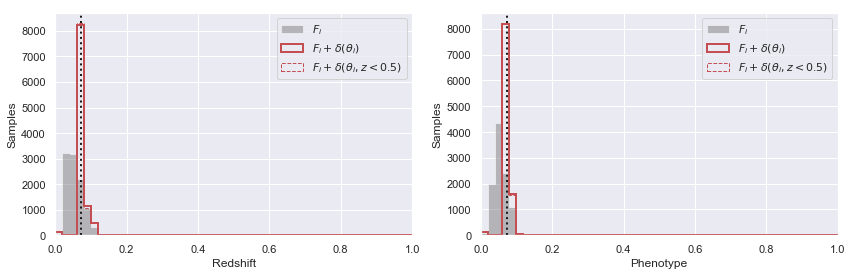

In [90]:
plot_one(1)

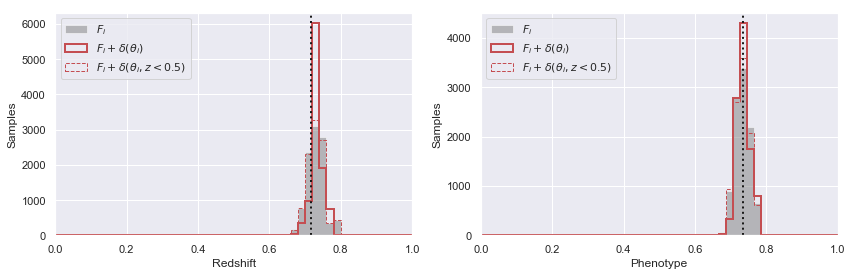

In [91]:
plot_one(8)

## Previous Material

In [274]:
z_test, t_test = gibbs_sampler(feature_data, prior_data, posterior='feature', seed=10, n_cycles=1)

Cycle 1 of 1


Sampling with feature-only posterior does indeed give a flat distribution for z:

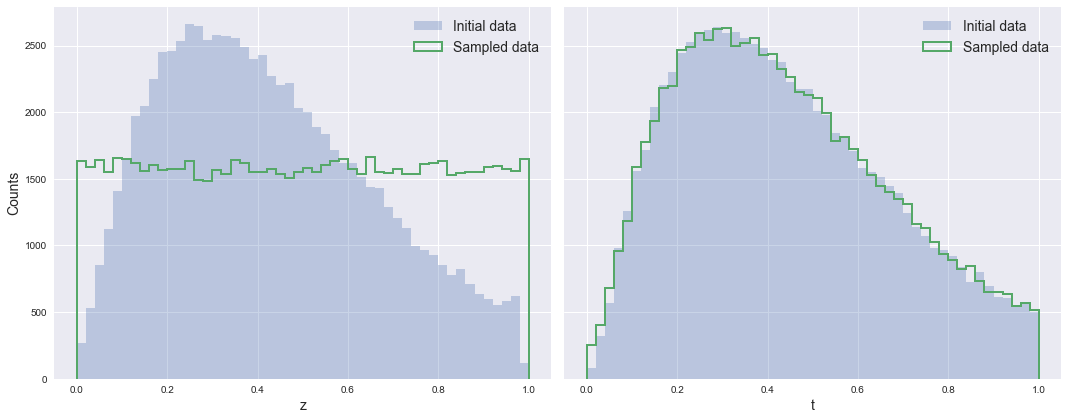

In [280]:
compare_distributions(feature_data, z_test, t_test)

In [282]:
assert len(feature_data) == len(z_test[-1])

Ok, seems to be working so far...need to run for 2500 cycles with 4 different seeds on Cori. Before that try running on for 100 cycles on laptop.

In [360]:
def gibbs_sampler_parallel(q, feature_data, prior_data, posterior, seed, sigma=sig_F, eps=1e-4, size=n_galaxies, n_cycles=100, save=True):
    
    rng = np.random.RandomState(seed)
    
    z_samples = np.empty((n_cycles, size), dtype=np.float64)
    t_samples = np.empty((n_cycles, size), dtype=np.float64)
    
    ## Initial data
    new_z = prior_data['z']
    new_t = prior_data['t']
    
    for cycle in range(n_cycles):
        
        print('Cycle {} of {}'.format(cycle+1, n_cycles))
    
        ## Calculate probabilities
        h, _, _ = np.histogram2d(new_z, new_t, bins=(z_bins, t_bins))
                    
        h[h == 0] = eps
        alpha = h.flatten()

        ## Generate Dirichlet posterior for probabilities
        dirichlet = scipy.stats.dirichlet.rvs(alpha, random_state=rng, size=1)
        dirichlet = dirichlet.reshape(nz,nt)
        
        ## Sample from posterior
        new_indices = np.empty(size, dtype=int)
        
        if posterior == 'dirichlet':
            probs = dirichlet
            probs /= np.sum(probs)
            new_indices = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=size, random_state=rng)
            new_indices = np.argmax(new_indices, axis=1)
            
        elif posterior=='feature':
            for k in range(size): 
                ## Generate probabilities from a normal distribution centered on the feature value 
                ## for that galaxy
                probs = scipy.stats.norm.pdf(x=t_mdpt, loc=feature_data['F'][k], scale=sigma)
                ## Next line is to make sure this has the same dimensions as Dirichlet so that when
                ## we're sampling indices we are sampling from a distribution of the same size 
                ## (i.e. with redshift + type information, not just type information)
                probs = np.full((nz,nt), probs)
                probs /= np.sum(probs)
                new_index = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=1, random_state=rng)
                new_indices[k] = np.argmax(new_index)
                    
        elif posterior=='dirichlet_feature':
            for k in range(size): 
                norm = scipy.stats.norm.pdf(x=t_mdpt, loc=feature_data['F'][k], scale=sigma)
                probs = dirichlet * norm
                probs /= np.sum(probs)
                new_index = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=1, random_state=rng)
                new_indices[k] = np.argmax(new_index)
                
        elif posterior=='all':
            for k in range(size): 
                norm = scipy.stats.norm.pdf(x=t_mdpt, loc=feature_data['F'][k], scale=sigma) 
                probs = dirichlet * norm * rho[feature_data['theta_x'][k], feature_data['theta_y'][k]].reshape(-1,1)
                probs /= np.sum(probs)
                new_index = scipy.stats.multinomial.rvs(n=1, p=probs.flatten(), size=1, random_state=rng)
                new_indices[k] = np.argmax(new_index)
                        
        new_iz, new_it = np.unravel_index(new_indices, (nz,nt))
        
        z_samples[cycle] = z_mdpt[new_iz]
        t_samples[cycle] = t_mdpt[new_it]
        
        ## Informative prior (Section 4.1.2) combines counts from previous cycle with the initial data
        new_z = np.concatenate((prior_data['z'].data, z_samples[cycle]), axis=None)
        new_t = np.concatenate((prior_data['t'].data, t_samples[cycle]), axis=None)
    
    if save:
        np.save('../data/bernstein_data/z_samples_{}_{}_{}'.format(posterior, seed, n_cycles), z_samples)
        np.save('../data/bernstein_data/t_samples_{}_{}_{}'.format(posterior, seed, n_cycles), t_samples)
    
    q.put([z_samples, t_samples])

In [361]:
seeds = [22, 33, 44, 55]

start = time.time()

q = Queue()
p1 = Process(target=gibbs_sampler_parallel, args=(q, feature_data, prior_data, 'dirichlet_feature', seeds[0]))
p1.start()
p2 = Process(target=gibbs_sampler_parallel, args=(q, feature_data, prior_data, 'dirichlet_feature', seeds[1]))
p2.start()
p3 = Process(target=gibbs_sampler_parallel, args=(q, feature_data, prior_data, 'dirichlet_feature', seeds[2]))
p3.start()
p4 = Process(target=gibbs_sampler_parallel, args=(q, feature_data, prior_data, 'dirichlet_feature', seeds[3]))
p4.start()
p5 = Process(target=gibbs_sampler_parallel, args=(q, feature_data, prior_data, 'all', seeds[0]))
p5.start()
p6 = Process(target=gibbs_sampler_parallel, args=(q, feature_data, prior_data, 'all', seeds[1]))
p6.start()
p7 = Process(target=gibbs_sampler_parallel, args=(q, feature_data, prior_data, 'all', seeds[2]))
p7.start()
p8 = Process(target=gibbs_sampler_parallel, args=(q, feature_data, prior_data, 'all', seeds[3]))
p8.start()

results = []
for i in range(len(seeds)):
    #set block=True to block until we get a result
    results.append(q.get(True))

p1.join()
p2.join()
p3.join()
p4.join()
p5.join()
p6.join()
p7.join()
p8.join()

print('Total time: {}'.format(time.time()-start))

Cycle 1 of 100
Cycle 1 of 100
Cycle 1 of 100
Cycle 1 of 100
Cycle 1 of 100
Cycle 1 of 100
Cycle 1 of 100
Cycle 1 of 100
Cycle 2 of 100
Cycle 2 of 100
Cycle 2 of 100
Cycle 2 of 100
Cycle 2 of 100
Cycle 2 of 100
Cycle 2 of 100
Cycle 2 of 100
Cycle 3 of 100
Cycle 3 of 100
Cycle 3 of 100
Cycle 3 of 100
Cycle 3 of 100
Cycle 3 of 100
Cycle 3 of 100
Cycle 3 of 100
Cycle 4 of 100
Cycle 4 of 100
Cycle 4 of 100
Cycle 4 of 100
Cycle 4 of 100
Cycle 4 of 100
Cycle 4 of 100
Cycle 4 of 100
Cycle 5 of 100
Cycle 5 of 100
Cycle 5 of 100
Cycle 5 of 100
Cycle 5 of 100
Cycle 5 of 100
Cycle 5 of 100
Cycle 5 of 100
Cycle 6 of 100
Cycle 6 of 100
Cycle 6 of 100
Cycle 6 of 100
Cycle 6 of 100
Cycle 6 of 100
Cycle 6 of 100
Cycle 6 of 100
Cycle 7 of 100
Cycle 7 of 100
Cycle 7 of 100
Cycle 7 of 100
Cycle 7 of 100
Cycle 7 of 100
Cycle 7 of 100
Cycle 7 of 100
Cycle 8 of 100
Cycle 8 of 100
Cycle 8 of 100
Cycle 8 of 100
Cycle 8 of 100
Cycle 8 of 100
Cycle 8 of 100
Cycle 8 of 100
Cycle 9 of 100
Cycle 9 of 100
Cycle 9 of

Process Process-28:
Process Process-27:
Process Process-26:
Process Process-25:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/process.py", line 257, in _bootstrap
    util._exit_function()
  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/process.py", line 257, in _bootstrap
    util._exit_function()
  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/process.py", line 257, in _bootstrap
    util._exit_function()
  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/util.py", line 313, in _exit_function
    _run_finalizers()
  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/util.py", line 313, in _exit_function
    _run_finalizers()


KeyboardInterrupt: 

  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/util.py", line 313, in _exit_function
    _run_finalizers()
  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/process.py", line 257, in _bootstrap
    util._exit_function()
  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/util.py", line 313, in _exit_function
    _run_finalizers()
  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/util.py", line 253, in _run_finalizers
    finalizer()
  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/util.py", line 253, in _run_finalizers
    finalizer()
  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/util.py", line 253, in _run_finalizers
    finalizer()
  File "/Users/belaabolfathi/anaconda3/lib/python3.5/multiprocessing/util.py", line 253, in _run_finalizers
    finalizer()


Combine output from the Gibbs sampler to make violin plots in Figure 3:

In [10]:
def stack_histograms(files, num_bins, bin_edges):
    
    init = np.load(files[0])
    n_cycles = init.shape[0]
    
    stacked = np.empty((len(files), n_cycles, num_bins), dtype=int)
    
    for i, fi in enumerate(files):
        try:
            dat = np.load(fi)
        except ValueError:
            print(i, fi)
        for j in range(n_cycles):
            stacked[i,j], _ = np.histogram(dat[j], bins=bin_edges)
        
    return(np.sum(stacked, axis=0) / len(files))

In [11]:
!ls ../data/bernstein_data/cori/

20190531                          z_samples_all_2.npy
t_samples_all_0.npy               z_samples_all_3.npy
t_samples_all_1.npy               z_samples_dirichlet_0.npy
t_samples_all_2.npy               z_samples_dirichlet_1.npy
t_samples_all_3.npy               z_samples_dirichlet_2.npy
t_samples_dirichlet_0.npy         z_samples_dirichlet_3.npy
t_samples_dirichlet_1.npy         z_samples_dirichlet_feature_0.npy
t_samples_dirichlet_2.npy         z_samples_dirichlet_feature_1.npy
t_samples_dirichlet_3.npy         z_samples_dirichlet_feature_2.npy
t_samples_dirichlet_feature_0.npy z_samples_dirichlet_feature_3.npy
t_samples_dirichlet_feature_1.npy z_samples_feature_0.npy
t_samples_dirichlet_feature_2.npy z_samples_feature_1.npy
t_samples_dirichlet_feature_3.npy z_samples_feature_2.npy
z_samples_all_0.npy               z_samples_feature_3.npy
z_samples_all_1.npy


In [21]:
## The data that are commented out had issues when running on Cori
## d = dirichlet prior, f = feature likelihood, df = dirichlet + feature likelihood, 
## all = dirichlet + feature + clustering
z_d = ['../data/bernstein_data/cori/z_samples_dirichlet_{}.npy'.format(i) for i in range(4)]
#t_d = ['../data/bernstein_data/cori/t_samples_dirichlet_{}.npy'.format(i) for i in range(4)]
z_f = ['../data/bernstein_data/cori/z_samples_feature_{}.npy'.format(i) for i in range(4)]
#t_f = ['../data/bernstein_data/cori/t_samples_feature{}.npy'.format(i) for i in range(4)]
z_df = ['../data/bernstein_data/cori/z_samples_dirichlet_feature_{}.npy'.format(i) for i in range(4)]
t_df = ['../data/bernstein_data/cori/t_samples_dirichlet_feature_{}.npy'.format(i) for i in range(4)]
z_all = ['../data/bernstein_data/cori/z_samples_all_{}.npy'.format(i) for i in range(4)]
t_all = ['../data/bernstein_data/cori/t_samples_all_{}.npy'.format(i) for i in range(4)]

In [17]:
t_df_hist = stack_histograms(t_df, nt, t_bins)
z_df_hist = stack_histograms(z_df, nz, z_bins)
z_all_hist = stack_histograms(z_all, nz, z_bins)
t_all_hist = stack_histograms(t_all, nt, t_bins)

In [52]:
blue = sns.xkcd_rgb["grey blue"]
red = sns.xkcd_rgb["coral"]
green = sns.xkcd_rgb["grey green"]

blue_patch = patches.Patch(color=blue)
red_patch = patches.Patch(color=red)
green_patch = patches.Patch(color=green)

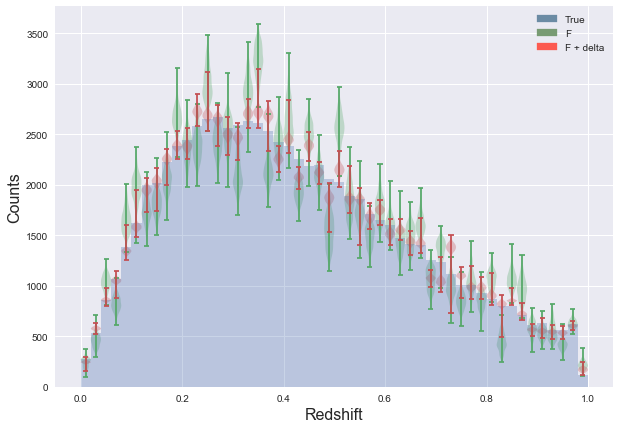

In [26]:
plt.figure(figsize=(10,7))
ax = plt.subplot(111)
plt.hist(feature_data['z'], bins=z_bins, alpha=0.3)
plt.violinplot(z_df_hist, z_mdpt, widths=0.02, points=40)
plt.violinplot(z_all_hist, z_mdpt, widths=0.02, points=40)
plt.xlabel('Redshift', fontsize=16)
plt.ylabel('Counts', fontsize=16)
ax.legend([blue_patch, green_patch, red_patch], ['True', 'F', 'F + delta'])
plt.show()

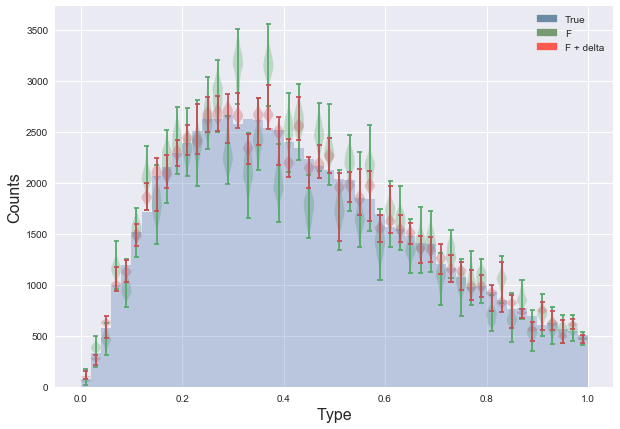

In [27]:
plt.figure(figsize=(10,7))
ax = plt.subplot(111)
plt.hist(feature_data['t'], bins=t_bins, alpha=0.3)
plt.violinplot(t_df_hist, t_mdpt, widths=0.02, points=40)
plt.violinplot(t_all_hist, t_mdpt, widths=0.02, points=40)
plt.xlabel('Type', fontsize=16)
plt.ylabel('Counts', fontsize=16)
ax.legend([blue_patch, green_patch, red_patch], ['True', 'F', 'F + delta'])
plt.show()

### $\Delta$z metric


Make a histogram of the difference between the recovered distribution of each sampled redshift histogram and the true redshift distribution (reproducing Figure 4). Each chain (represented as a single .npy file) contains 2500 samples, and each sample contains 79000 galaxies. Each posterior type (i.e. dirichlet, dirichlet + feature, etc.) therefore has 4 chains x 2500 = 10000 samples each.

In [28]:
z_d_0 = np.load('../data/bernstein_data/cori/z_samples_dirichlet_0.npy')
z_d_1 = np.load('../data/bernstein_data/cori/z_samples_dirichlet_1.npy')
z_d_2 = np.load('../data/bernstein_data/cori/z_samples_dirichlet_2.npy')
z_d_3 = np.load('../data/bernstein_data/cori/z_samples_dirichlet_3.npy')

In [29]:
z_df_0 = np.load('../data/bernstein_data/cori/z_samples_dirichlet_feature_0.npy')
z_df_1 = np.load('../data/bernstein_data/cori/z_samples_dirichlet_feature_1.npy')
z_df_2 = np.load('../data/bernstein_data/cori/z_samples_dirichlet_feature_2.npy')
z_df_3 = np.load('../data/bernstein_data/cori/z_samples_dirichlet_feature_3.npy')

In [30]:
z_all_0 = np.load('../data/bernstein_data/cori/z_samples_all_0.npy')
z_all_1 = np.load('../data/bernstein_data/cori/z_samples_all_1.npy')
z_all_2 = np.load('../data/bernstein_data/cori/z_samples_all_2.npy')
z_all_3 = np.load('../data/bernstein_data/cori/z_samples_all_3.npy')

In [31]:
print(z_d_0.shape)
print(z_df_0.shape)
print(z_all_0.shape)

(2500, 79000)
(2500, 79000)
(2500, 79000)


In [33]:
z_d_concat = np.concatenate((z_d_0, z_d_1, z_d_2, z_d_3), axis=0)
z_df_concat = np.concatenate((z_df_0, z_df_1, z_df_2, z_df_3), axis=0)
z_all_concat = np.concatenate((z_all_0, z_all_1, z_all_2, z_all_3), axis=0)

In [36]:
del_z_d = np.mean(z_d_concat, axis=1) - np.mean(feature_data['z'])
del_z_df = np.mean(z_df_concat, axis=1) - np.mean(feature_data['z'])
del_z_all = np.mean(z_all_concat, axis=1) - np.mean(feature_data['z'])

In [120]:
d_mu = np.mean(del_z_d)
df_mu = np.mean(del_z_df)
all_mu = np.mean(del_z_all)

In [124]:
fs = 14

In [197]:
bin_edges = np.linspace(-0.008, 0.0045, 30)

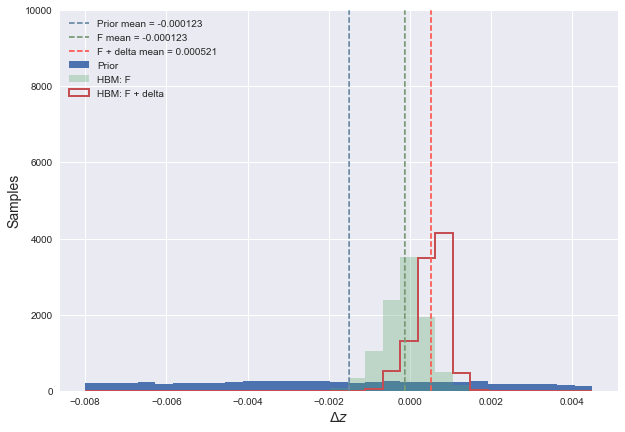

In [199]:
ylim = 10000
## 10000 histograms
plt.figure(figsize=(10,7))
plt.hist(del_z_d, bins=bin_edges, range=(-0.008,0.005), label='Prior')
plt.hist(del_z_df, bins=bin_edges, range=(-0.008,0.005), label='HBM: F', alpha=0.3)
plt.hist(del_z_all, bins=bin_edges, range=(-0.008,0.005), histtype='step', lw=2, label='HBM: F + delta')
plt.plot(np.full(ylim, d_mu), np.arange(0,ylim), c=blue, ls='--', label='Prior mean = {:2f}'.format(df_mu))
plt.plot(np.full(ylim, df_mu), np.arange(0,ylim), c=green, ls='--', label='F mean = {:2f}'.format(df_mu))
plt.plot(np.full(ylim, all_mu), np.arange(0,ylim), c=red, ls='--', label='F + delta mean = {:2f}'.format(all_mu))
plt.xlabel('$\Delta z$', fontsize=fs)
plt.ylabel('Samples', fontsize=fs)
plt.ylim(0,ylim)
plt.legend(loc=2)
plt.show()

Next: separate low redshift (z < 0.5) samples.

In [200]:
## Select all z < 0.5 from both z_all_concat and feature_data
z_all_lowz = np.where(z_all_concat < 0.5, z_all_concat, np.nan)
feature_data_lowz = np.where(feature_data['z'] < 0.5, feature_data['z'], np.nan)

In [201]:
del_zall_lowz = np.nanmean(z_all_lowz, axis=1) - np.nanmean(feature_data_lowz)

In [202]:
lowz_mu = np.mean(del_zall_lowz)

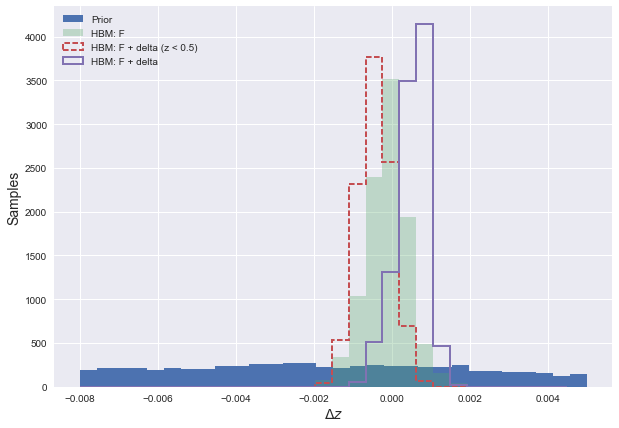

In [204]:
plt.figure(figsize=(10,7))
plt.hist(del_z_d, bins=30, range=(-0.008,0.005), label='Prior')
plt.hist(del_z_df, bins=bin_edges, range=(-0.008,0.005), label='HBM: F', alpha=0.3)
plt.hist(del_zall_lowz, bins=bin_edges, range=(-0.008,0.005), histtype='step', ls='--', lw=2, label='HBM: F + delta (z < 0.5)')
plt.hist(del_z_all, bins=bin_edges, range=(-0.008,0.005), histtype='step', lw=2, label='HBM: F + delta')
plt.xlabel('$\Delta z$', fontsize=fs)
plt.ylabel('Samples', fontsize=fs)
plt.legend(loc=2)
plt.show()

In [206]:
z_all_highz = np.where(z_all_concat > 0.5, z_all_concat, np.nan)
feature_data_highz = np.where(feature_data['z'] > 0.5, feature_data['z'], np.nan)

In [209]:
highz = z_all_concat[z_all_concat >= 0.5]

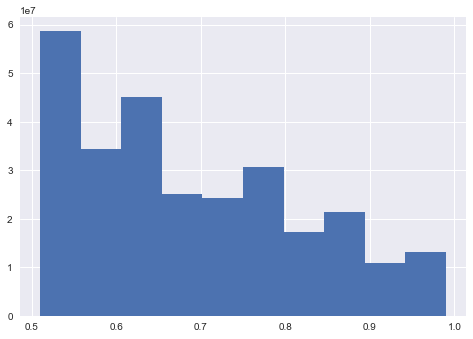

In [213]:
plt.hist(highz)
#plt.hist(feature_data['z'][feature_data['z'] >= 0.5])
plt.show()

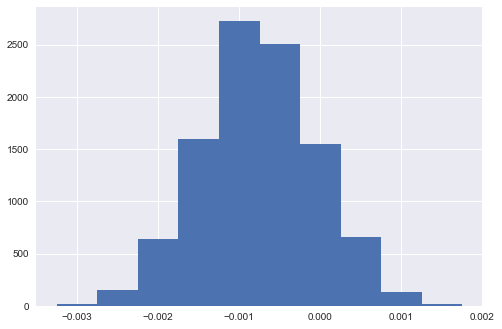

In [221]:
plt.hist(np.nanmean(z_all_highz, axis=1) - np.nanmean(feature_data_highz))
plt.show()

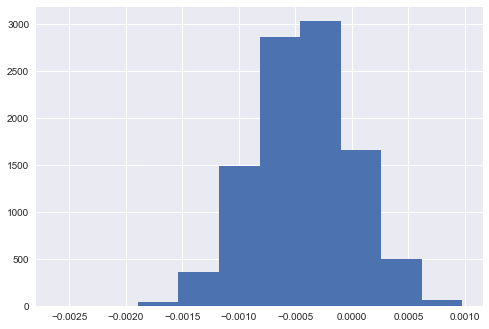

In [222]:
plt.hist(del_zall_lowz)
plt.show()

In [217]:
np.nanmean(feature_data_highz)

0.6875567435702117

In [216]:
np.mean(highz)

0.6867943191126418

In [215]:
np.mean(feature_data['z'][feature_data['z'] >= 0.5])

0.6875567435702118

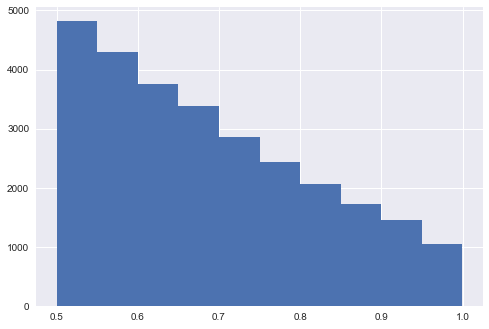

In [223]:
plt.hist(feature_data['z'][feature_data['z'] >= 0.5])
plt.show()

## Scratch work

### Let's compare the output from the last cycle of each chain to the original redshift and type distributions:

In [77]:
def compare_distributions(initial_data, sampled_z, sampled_t):
    
    fig, axs = plt.subplots(1,2, figsize=(15,6), sharey=True)
    axs = axs.ravel()

    axs[0].hist(initial_data['z'], bins=z_bins, alpha=0.3, label='Initial data')
    axs[0].hist(sampled_z[-1], bins=z_bins, histtype='step', lw=2, label='Sampled data')
    axs[1].hist(initial_data['t'], bins=t_bins, alpha=0.3, label='Initial data')
    axs[1].hist(sampled_t[-1], bins=t_bins, histtype='step', lw=2, label='Sampled data')
    
    axs[0].set_ylabel('Counts', fontsize=fs)
    axs[0].set_xlabel('z', fontsize=fs)
    axs[1].set_xlabel('t', fontsize=fs)
    
    axs[0].legend(fontsize=fs)
    axs[1].legend(fontsize=fs)
    
    plt.tight_layout()
    plt.show()

### Case 1) Use the entire initial data set as our prior

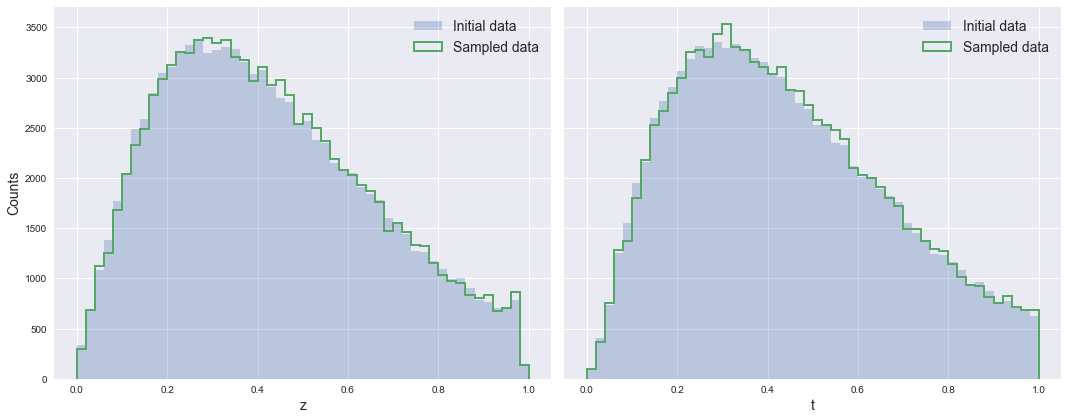

In [78]:
compare_distributions(galaxies, z_dirichlet, t_dirichlet)

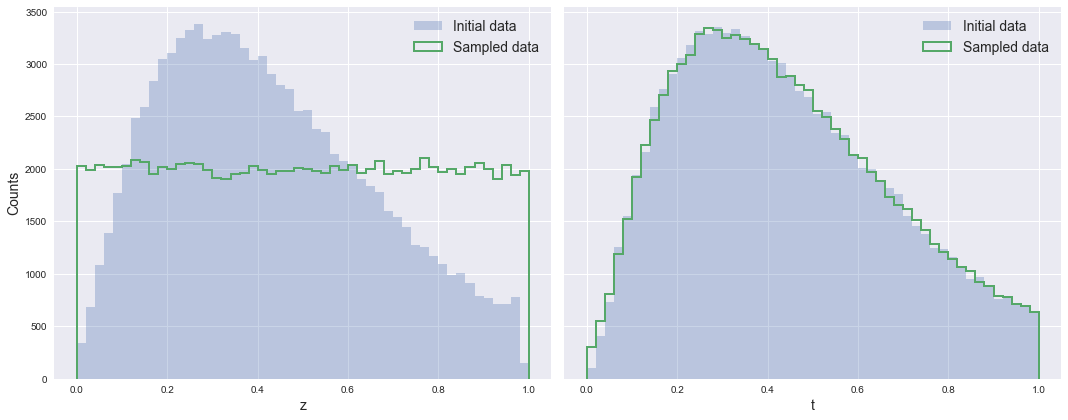

In [79]:
compare_distributions(galaxies, z_feature, t_feature)

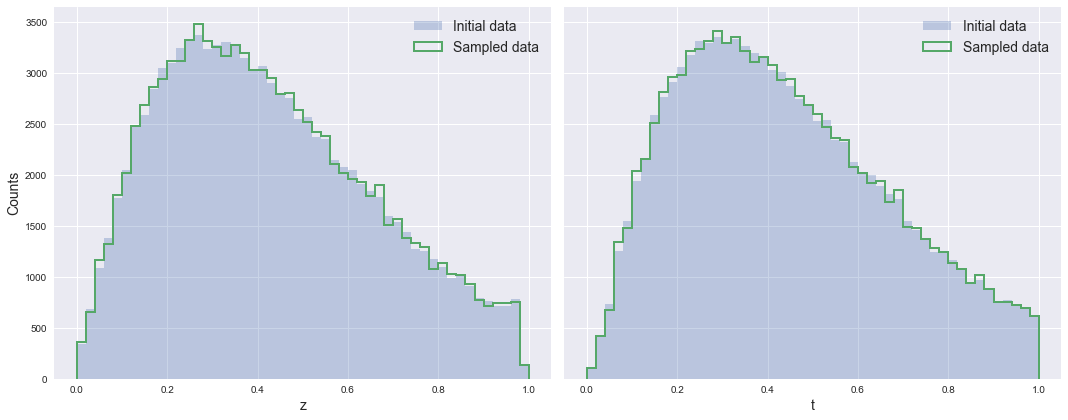

In [80]:
compare_distributions(galaxies, z_dirichlet_feature, t_dirichlet_feature)

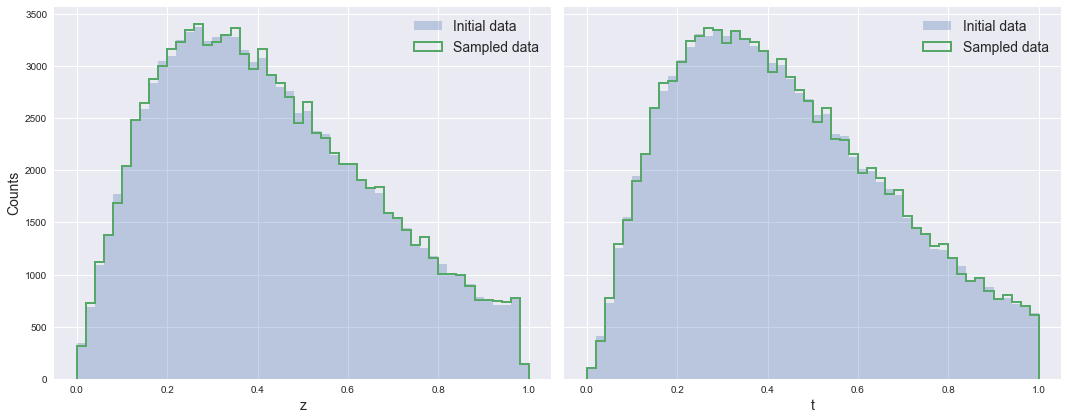

In [81]:
compare_distributions(galaxies, z_all, t_all)

### Case 2) Use one third of the entire initial data set as our prior

In [97]:
n_cycles = 20

In [88]:
## Dirichlet only
z_dirichlet, t_dirichlet = gibbs_sampler(initial_data=galaxies, posterior='dirichlet', 
                                         seed=walker_seed, fraction=33333, n_cycles=n_cycles)

Cycle 1 of 5
Cycle 2 of 5
Cycle 3 of 5
Cycle 4 of 5
Cycle 5 of 5


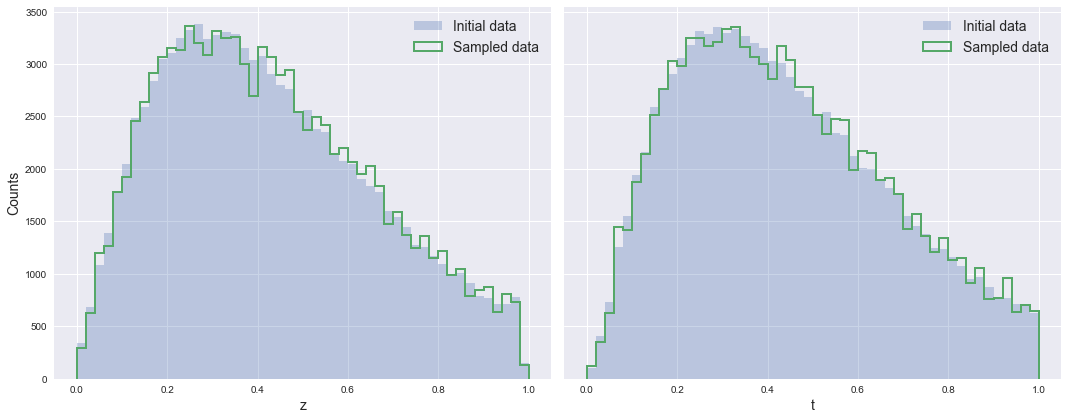

In [89]:
compare_distributions(galaxies, z_dirichlet, t_dirichlet)

In [90]:
## Feature likelihood only
z_feature, t_feature = gibbs_sampler(initial_data=galaxies, posterior='feature', 
                                         seed=walker_seed, n_cycles=n_cycles)

Cycle 1 of 5
Cycle 2 of 5
Cycle 3 of 5
Cycle 4 of 5
Cycle 5 of 5


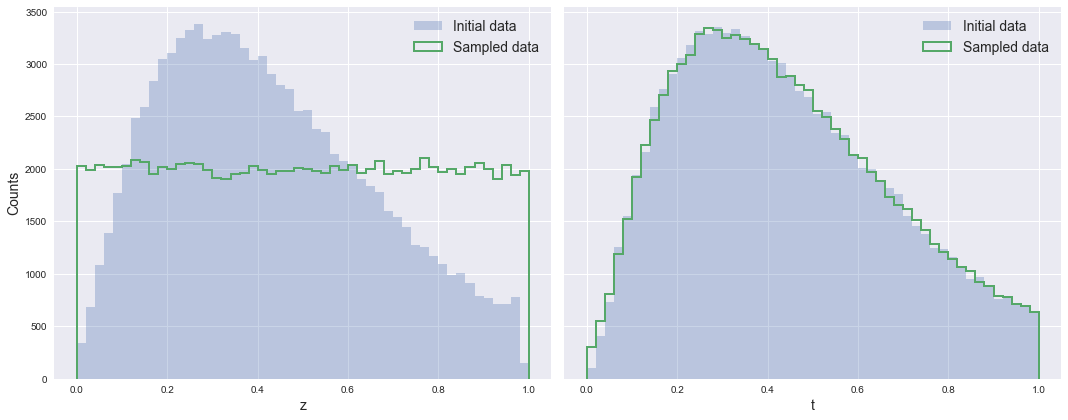

In [91]:
compare_distributions(galaxies, z_feature, t_feature)

In [98]:
## Dirichlet + feature likelihood
z_dirichlet_feature, t_dirichlet_feature = gibbs_sampler(initial_data=galaxies, posterior='dirichlet_feature', 
                                         seed=walker_seed, n_cycles=n_cycles)

Cycle 1 of 20
Cycle 2 of 20
Cycle 3 of 20
Cycle 4 of 20
Cycle 5 of 20
Cycle 6 of 20
Cycle 7 of 20
Cycle 8 of 20
Cycle 9 of 20
Cycle 10 of 20
Cycle 11 of 20
Cycle 12 of 20
Cycle 13 of 20
Cycle 14 of 20
Cycle 15 of 20
Cycle 16 of 20
Cycle 17 of 20
Cycle 18 of 20
Cycle 19 of 20
Cycle 20 of 20


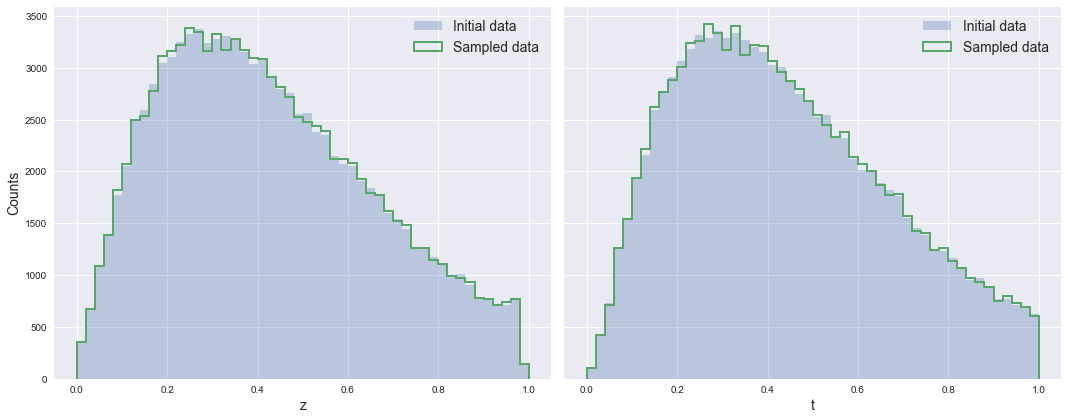

In [99]:
compare_distributions(galaxies, z_dirichlet_feature, t_dirichlet_feature)

In [100]:
## Dirichlet + feature likelihood + delta field
z_all, t_all = gibbs_sampler(initial_data=galaxies, posterior='all', 
                                         seed=walker_seed, n_cycles=n_cycles)

Cycle 1 of 20
Cycle 2 of 20
Cycle 3 of 20
Cycle 4 of 20
Cycle 5 of 20
Cycle 6 of 20
Cycle 7 of 20
Cycle 8 of 20
Cycle 9 of 20
Cycle 10 of 20
Cycle 11 of 20
Cycle 12 of 20
Cycle 13 of 20
Cycle 14 of 20
Cycle 15 of 20
Cycle 16 of 20
Cycle 17 of 20
Cycle 18 of 20
Cycle 19 of 20
Cycle 20 of 20


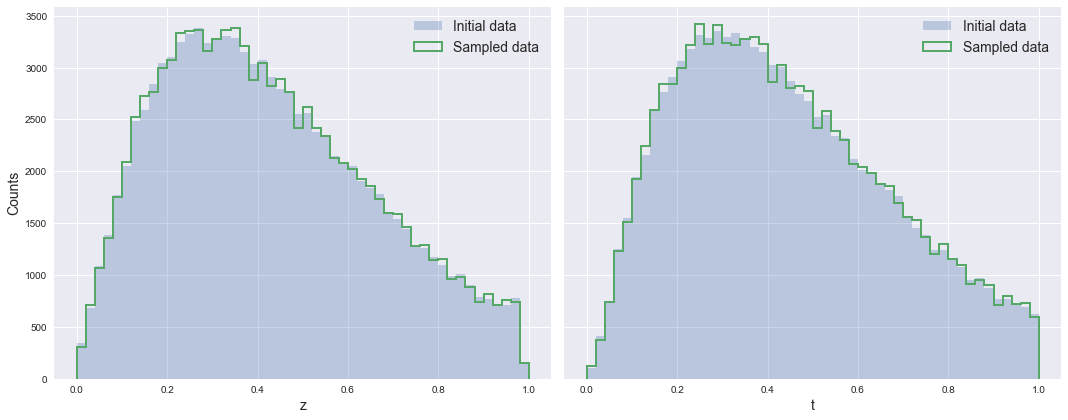

In [101]:
compare_distributions(galaxies, z_all, t_all)